In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
import itertools
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import coverage_error
from sklearn.svm import SVC
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.neural_network import MLPClassifier
import scipy.sparse
from sklearn.metrics import f1_score

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup

#from sklearn.preprocessing import StandardScaler

from scipy.sparse import coo_matrix, hstack


In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

# Dataset preparation

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

In [8]:
dataset.head()

,TText,TText_NEG,PText,TCode,PCode,TTitle,TTitle_NEG,Title,PTags,Tags
Id,,,,,,,,,,
48174988,'m tri understand local global variabl differ ...,'m tri understand local global variabl differ ...,I'm trying to understand how local and global...,tf . local_variables_initializer tf . local_va...,tf.local_variables_initializer tf.local_variab...,tensorflow creat local variabl,tensorflow creat local variabl,Tensorflow: how to create a local variable?,['tensorflow'],<tensorflow>
48061406,uniti export script basic store bone 's rotat ...,uniti export script basic store bone 's rotat ...,My Unity exporter script basically stores the...,using System . Collections ; using System . Co...,using System.Collections;\nusing System.Collec...,convert coordin system caus rotation/gimb issu...,convert coordin system caus rotation/gimb issu...,Converting between coordinate systems causing ...,"['c#', 'unity3d', 'coordinate-systems', 'rotat...",<c#><unity3d><coordinate-systems><rotational-m...
48092043,bit odd question speadsheet move pictur around...,bit odd question speadsheet move pictur around...,This is a bit of an odd question. I have a sp...,Public PositionTop As Double Public PositionLe...,Public PositionTop As Double\nPublic PositionL...,excel vba anim move object,excel vba anim move object,Excel VBA: Animation of moving object,"['excel', 'vba', 'excel-vba', 'object']",<excel><vba><excel-vba><object>
48183963,'m quit new tensorflow machin learn right woul...,'m quit new tensorflow machin learn right woul...,i'm quite new to Tensorflow and machine learn...,None,None,tensorflow dublic check best place start,tensorflow dublic check best place start,Tensorflow for dublicate check: Best place to ...,['tensorflow'],<tensorflow>
48055150,queri setup like follow need result tri work s...,queri setup like follow need result tri work_N...,I have a query setup like follows: I need the...,PEmpID / PEmplye / PPay / PTip / BEmpID / BEmp...,PEmpID / PEmplye / PPay / PTip / BEm...,tri sum select row multipl instanc,tri sum select row multipl instanc,trying to sum select rows for multiple instances,['ms-access-2010'],<ms-access-2010>


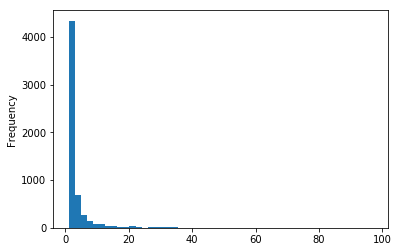

In [9]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()




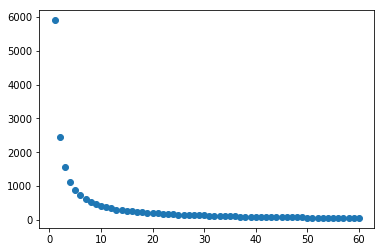

In [10]:
#Sample size according tag popularity
x=range(1,61)
y=[]
for numtag in x:
    y.append(df[df>=numtag].shape[0])
plt.scatter(x,y)

plt.show()

In [11]:
popularitytags = df[df>50].to_dict()
len(popularitytags)

69

In [12]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(7940, 12)


,PTagsCleaned,PTags,TCode
Id,,,
48174988,[tensorflow],[tensorflow],tf . local_variables_initializer tf . local_va...
48061406,[c#],"[c#, unity3d, coordinate-systems, rotational-m...",using System . Collections ; using System . Co...
48092043,"[excel, vba, excel-vba]","[excel, vba, excel-vba, object]",Public PositionTop As Double Public PositionLe...
48183963,[tensorflow],[tensorflow],None
48096578,"[java, sql, sql-server]","[java, sql, sql-server, jdbc, prepared-statement]",String uploadQuery = UploadUtilManager . getUp...


http://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification-format

# Dataset preparation

In [13]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [14]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(7940, 69)

In [15]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

# Custom TFidf  function

In [16]:
#Custom TfIDF creation

class Customtfidf(BaseEstimator, TransformerMixin):

    def __init__(self, **params):
        
        self.params={
            'text_max_features':None, 'title_max_features':None, 'code_max_features':None,
            'text_min_df':1, 'title_min_df':1, 'code_min_df':1,
            'text_max_df':1., 'title_max_df':1., 'code_max_df':1.,
            'text_ngram_range':(1,1), 'title_ngram_range':(1,1), 'code_ngram_range':(1,1),
                    }
        self.params = {**self.params, **params}
        
        self.textparams = {}
        self.titleparams = {}
        self.codeparams = {}
        
        self.update_params()
        
    

    def fit(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        self.update_params()
        
        #Text preparation
        self.texttfidf = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.textparams)
        self.texttfidf.fit(dftext)
        
        #Title preparation
        self.titletfidf = CountVectorizer(tokenizer=None, vocabulary=None, **self.titleparams)
        self.titletfidf.fit(dftitle)

        
        #Code preparation
        self.codetfidf = CountVectorizer(tokenizer=None, vocabulary=None, **self.codeparams)
        self.codetfidf.fit(dfcode)
        return self
    
    def transform(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        #Text preparation
        texttfidf = self.texttfidf.transform(dftext)
        
        #Title preparation
        titletfidf = self.titletfidf.transform(dftitle)
    
        #Code preparation
        codetfidf = self.codetfidf.transform(dfcode)
        
        return scipy.sparse.hstack((texttfidf, titletfidf, codetfidf), format='csr')
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        #print({**params})
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        self.textparams = {k[5:]:v for k,v in self.params.items() if k.startswith('text')}
        self.titleparams = {k[6:]:v for k,v in self.params.items() if k.startswith('title')}
        self.codeparams = {k[5:]:v for k,v in self.params.items() if k.startswith('code')}
        return self
    


customtfidf = Customtfidf()
#Customtfidf.fit(textset[['TText', 'TTitle', 'TCode']])
#print('Step1 done')
#XX = customtfidf.fit_transform(X_train)#.shape

# Randomforrest version

In [17]:
class Customtclf(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.clf = RandomForestClassifier(random_state=0)
        self.params = {**{'limit':.15}, **kwargs}
        
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        self.limit=self.params['limit']
        
        self.clf.set_params(**self.clfparams)
    
    def fit(self, X, y):
        self.clf = RandomForestClassifier(random_state=0)
        self.clf.set_params(**self.clfparams)
        self.clf.fit(X, y)
        return self
    
    def predict(self, X):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , 1, 0)
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)
    
    def predict_proba(self, X, y=None):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , proba[:,1], proba[:,0])
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)
        

    def set_params(self, **params):
        self.params = {**self.params, **params}
        
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        #print(self.clfparams)
        self.limit=self.params['limit']
        return self
        
    def get_params(self, deep=True):
        return self.params
    
    def score(self, X, y):
        return self.clf.score(X, y)

customclf = Customtclf()
#XX=customtfidf.fit_transform(X_train)
    
#rmf = RandomForestClassifier(random_state=0)
#customclf = Customtclf()
#customclf.fit(XX, y_train)
        
        
    

In [18]:
#Metrics creation

scorer = make_scorer(f1_score, average='micro')


In [19]:
#Gridsearch creation Step1
#Pipeline creation
pipe = [('customtfidf', Customtfidf()), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters1 = {
              'customtfidf__text_max_features':[20000, 15000, 25000],
              'customtfidf__text_max_df':[1.,.95],
              'customtfidf__text_min_df':[1, 10, 20],
              'customtfidf__text_ngram_range':[(1,1), (1,2), (1,3)],
              'customclf__limit':[.2,.4, .3],
              #'customclf__min_samples_split':[2,10,20],
              #'customclf__min_samples_leaf':[1,3,5],
              }

clf1 = GridSearchCV(kpipeline, parameters1, verbose = 3, cv = 3, n_jobs=3, return_train_score=True, scoring=scorer)
clf1.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.606123508043591, total=   8.5s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.6055988660524451, total=   8.5s
[CV]  customclf__limit=0.2, customtfidf__text_max_d

[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.6079555323953448, total=   8.5s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.6088659426740253, total=   8.6s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.5886712546320805, total=   8.5s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfid

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.7min


[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.606123508043591, total=   8.5s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.6055988660524451, total=   8.4s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.6051336146272854, total=   8.5s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__tex

[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.5886712546320805, total=   8.4s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.6046028724692852, total=   9.7s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.5985915492957747, total=   9.7s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfid

[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.6089720946661957, total=   7.7s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.5939501779359431, total=   7.7s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf_

[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.6024219682756268, total=   9.9s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.6001058387722702, total=   9.8s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, custom

[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.5986250661025911, total=   8.3s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.6029179117595359, total=   8.4s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, custom

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.5min


[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.6157894736842106, total=   9.1s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.6024219682756268, total=  10.1s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.5999301187980434, total=  10.1s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.6001058387722702, total=  10.0s
[CV] customclf__limit

[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.6029179117595359, total=   8.1s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.5986250661025911, total=   8.0s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, custom

[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.45553036029226507, total=  12.8s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.4374675661650233, total=  12.7s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__te

[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.4298820445609437, total=   8.8s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.4315157839812157, total=   8.7s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.4623628476652207, total=  10.0s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__te

[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.4393510172546999, total=   9.8s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.4417463187806769, total=   9.8s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.4244812188074599, total=   9.7s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf

[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.4204695331047217, total=   8.1s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.44005134788189987, total=   9.1s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf

[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.4543610547667342, total=  11.0s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.4360238774980535, total=  10.8s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.44155167925019523, total=  11.0s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, cus

[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.44039562727745973, total=   8.5s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.4315265776381252, total=   8.4s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 17.7min


[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.4656430908633275, total=   9.1s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.4617752693689072, total=   9.1s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.4516790566521405, total=   9.1s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, cust

[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.45144890696492124, total=   8.3s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.4315265776381252, total=   8.3s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, custo

[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.562128876182098, total=  10.5s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.5515232974910393, total=  10.5s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_

[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.5461335676625659, total=   9.1s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.5399684755685658, total=   9.0s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text

[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.562807331247206, total=   9.1s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.5395894428152492, total=   9.0s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.5488556338028169, total=  10.3s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf

[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.5617229129662522, total=   8.3s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.5647969052224372, total=   8.4s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.535344439441693, total=   8.3s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf

[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.5596432552954292, total=   9.1s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.561131992040681, total=   9.1s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.5700129254631624, total=  10.6s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, cust

[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.558855408627791, total=   8.4s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.5480878026702873, total=   8.3s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.5546218487394958, total=   8.4s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, custo

[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.5590533601250279, total=  11.5s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.5558015943312666, total=  11.4s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.5754961173425367, total=  12.4s
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtf

[Parallel(n_jobs=3)]: Done 486 out of 486 | elapsed: 30.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), text_max_df=1.0, text_max_features=None,
      text_min_df=1, text_ngram_range=(1, 1), title_max_df=1.0,
      title_max_features=None, title_min_df=1, title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__text_max_features': [20000, 15000, 25000], 'customtfidf__text_max_df': [1.0, 0.95], 'customtfidf__text_min_df': [1, 10, 20], 'customtfidf__text_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customclf__limit': [0.2, 0.4, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [20]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.61913608917789142

In [21]:
clf1.score(X_test, y_test)

0.61913608917789142

In [22]:
clf1.best_params_

{'customclf__limit': 0.2,
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 15000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 2)}

In [23]:
#Gridsearch creation Step2

init1 = clf1.best_params_
init1 = {k:v for k,v in init1.items() if k.startswith('customtfidf')}

pipe = [('customtfidf', Customtfidf(**init1)), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters2 = {
              'customtfidf__title_max_features':[5000, 6000, 4000],
              'customtfidf__title_max_df':[1.,.95],
              'customtfidf__title_min_df':[1, 10, 20],
              'customtfidf__title_ngram_range':[(1,1), (1,2), (1,3)],
              'customclf__limit':[.2,.4],
              #'customclf__min_samples_split':[2,5],
              #'customclf__min_samples_leaf':[1,5],
              }

clf2 = GridSearchCV(kpipeline, parameters2, verbose = 3, cv = 3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf2.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.606123508043591, total=   8.9s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title

[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.6139359698681733, total=   8.9s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.6054131054131053, total=   8.9s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.6029723991507431, total=   8.9s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.6min


[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.606123508043591, total=   8.8s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.6055988660524451, total=   8.7s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, cu

[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.6054131054131053, total=   9.8s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.6029723991507431, total=   9.8s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=60

[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.6070620977561314, total=   9.4s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.6051883439943141, total=   9.4s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=400

[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.598836184094516, total=   9.7s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.6019108280254777, total=   9.8s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_featur

[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.6122736064708986, total=   9.9s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.6069394096323149, total=   9.2s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.6078431372549019, total=   9.0s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.5988320651212174, total=   9.1s
[CV] cu

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.5min


[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.6109777015437392, total=   9.1s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.6019108280254777, total=   9.0s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.598836184094516, total=   9.1s
[CV] customclf__limit=0.2, customtfidf__title_ma

[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.6078431372549019, total=   8.3s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.6109777015437392, total=   8.4s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_featur

[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.45034465151901965, total=   8.8s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.4398963730569948, total=   8.7s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.44415584415584414, total=   8.8s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1

[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.4315157839812157, total=   8.5s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.4298820445609437, total=   8.6s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.457433290978399, total=   8.7s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, 

[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.45472938796155793, total=   8.6s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.42913077525450277, total=   8.6s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.424607329842932, total=   8.6s
[CV] customclf__limit=0.4, customtfidf__title_max_df

[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.42717935212009484, total=   8.4s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.45472938796155793, total=   8.6s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=

[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.4669182389937107, total=   9.3s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.43047221497521526, total=   9.2s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.439417576703068, total=   9.2s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__title_m

[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.43585053566762477, total=   8.3s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.42579968536969065, total=   8.2s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 16.6min


[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.4669182389937107, total=   8.3s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.43047221497521526, total=   8.3s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_feat

[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.4198692810457516, total=   8.7s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.44967658473479943, total=   8.8s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_featur

[Parallel(n_jobs=3)]: Done 324 out of 324 | elapsed: 19.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=15000, customtfidf__text_min_df=1,
      customtfidf__text_ngram_range=(1, 2), text_max_df=1.0,
      text_max_..._min_df=1,
      title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__title_max_features': [5000, 6000, 4000], 'customtfidf__title_max_df': [1.0, 0.95], 'customtfidf__title_min_df': [1, 10, 20], 'customtfidf__title_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customclf__limit': [0.2, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [24]:
clf2.score(X_test, y_test)

0.61988716502115648

In [25]:
f1_score(y_test, clf2.predict(X_test), average='micro')

0.61988716502115648

In [26]:
clf2.best_params_

{'customclf__limit': 0.2,
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 6000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 3)}

In [27]:
#Gridsearch creation Step3

init2 = clf2.best_params_
init2 = {k:v for k,v in init2.items() if k.startswith('customtfidf')}
init2 = {**init2, **init1}

pipe = [('customtfidf', Customtfidf(**init2)), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters3 = {
              'customtfidf__code_max_features':[15000, 10000, 20000],
              'customtfidf__code_max_df':[1.,.95],
              'customtfidf__code_min_df':[1, 10, 20],
              'customtfidf__code_ngram_range':[(1,1), (1,2), (1,3)],
              'customclf__limit':[.2,.3,.4],
              #'customclf__min_samples_split':[2,5],
              #'customclf__min_samples_leaf':[1,5],
              }

clf3 = GridSearchCV(kpipeline, parameters3, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf3.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.6117687424944244, total=   7.9s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.6115760111576011, total=   7.8s
[CV] customclf__limit=0.2, customtfidf__code_max_d

[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.6160773849232822, total=   8.5s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.6161169670180211, total=   8.4s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.6168641593680234, total=   8.4s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfid

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.7min


[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.6147053829173035, total=   7.4s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.6075465136498, total=   7.4s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.6182501708817498, total=   7.5s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_

[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.6168641593680234, total=   8.8s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.6192893401015228, total=  10.9s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.6215615923458057, total=  11.0s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfid

[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.614102118791247, total=   7.1s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.6123711340206185, total=   7.1s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__

[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.6186703410265243, total=   9.1s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.6167694615769295, total=  10.7s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.616637781629116, total=  10.7s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, cust

[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.6184392265193369, total=   7.3s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.6172797262617622, total=   7.3s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, custom

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.7min


[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.6167694615769295, total=  10.5s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.6133931653434588, total=  10.4s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, custom

[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.6184392265193369, total=   7.3s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.6172797262617622, total=   7.3s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, custom

[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.5917555974053149, total=  11.3s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.593949723050703, total=  11.3s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code

[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.584101135633169, total=   7.6s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.6001648804616653, total=   9.1s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_

[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.5842368640533778, total=  10.2s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.5767903364969801, total=  10.2s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.5897544453852668, total=  10.3s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf_

[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.5921299188007495, total=   8.7s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.5803438760348122, total=   8.7s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf_

[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.5972486772486773, total=  10.5s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.578765645230902, total=  10.4s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customt

[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.5713041585020684, total=   7.2s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 17.4min


[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.6092851273623664, total=   9.0s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.5907744392721117, total=   8.9s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.5886872998932764, total=   8.9s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, cust

[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.5755675675675676, total=  11.6s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.5816433200919925, total=   7.2s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customt

[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.5003629324945561, total=   9.3s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4882909815645241, total=   9.3s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4789789789789789, total=   9.3s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__co

[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.46395609877775007, total=   7.7s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.48971499380421313, total=   7.8s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__cod

[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.49348093480934807, total=   8.4s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.4848185633176993, total=   8.4s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf

[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.4666166541635409, total=   7.5s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.46040234275528386, total=   7.6s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf

[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.5089307560557866, total=   9.4s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.49496190710248217, total=   9.5s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, custo

[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.4904738641914997, total=   7.7s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.4872944693572496, total=   7.9s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, custom

[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4852393946911437, total=   9.7s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4816204051012753, total=   9.6s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf

[Parallel(n_jobs=3)]: Done 486 out of 486 | elapsed: 30.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=15000, customtfidf__text_min_df=1,
      customtfidf__text_ngram_range=(1, 2), customtfidf__title_max_df=1.0,
 ..._min_df=1,
      title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__code_max_features': [15000, 10000, 20000], 'customtfidf__code_max_df': [1.0, 0.95], 'customtfidf__code_min_df': [1, 10, 20], 'customtfidf__code_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customclf__limit': [0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [28]:
clf3.score(X_test, y_test)

0.63155505107832011

In [29]:
f1_score(y_test, clf3.predict(X_test), average='micro')

0.63155505107832011

In [30]:
clf3.best_params_

{'customclf__limit': 0.2,
 'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 10,
 'customtfidf__code_ngram_range': (1, 2)}

In [31]:
init3 = clf3.best_params_
init3 = {k:v for k,v in init3.items() if k.startswith('customtfidf')}
init3 = {**init3, **init2, **init1}
init3

{'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 10,
 'customtfidf__code_ngram_range': (1, 2),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 15000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 2),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 6000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 3)}

In [32]:
#Gridsearch creation Step4

pipe = [('customtfidf', Customtfidf(**init3)), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters4 = {
              'customclf__limit':[.3,.35, .25, .2, .15],
              'customclf__min_samples_split':[20,10, 15],
              'customclf__min_samples_leaf':[1,3],
              }


clf4 = GridSearchCV(kpipeline, parameters4, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf4.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20 
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20 
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20 
[CV]  customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20, score=0.5216178521617851, total=   6.8s
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=10 
[CV]  customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20, score=0.5020576131687243, total=   6.7s
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=10 
[CV]  customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20, score=0.5154983309489748, total=   7.3s
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=1

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.1min


[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20 
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.32045454545454544, total=   4.2s
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.3284692417739628, total=   4.3s
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.31841652323580033, total=   4.2s
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.31492027334851935, total=   4.1s
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=15 
[CV] 

[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.5640916808149405, total=   4.1s
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.5720241817802794, total=   4.2s
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.5733113673805602, total=   4.1s
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=15 
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.5632670334320778, total=   4.1s
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.57268537

[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=10,
      customtfidf__code_ngram_range=(1, 2), customtfidf__text_max_df=1.0,
 ..._min_df=1,
      title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customclf__limit': [0.3, 0.35, 0.25, 0.2, 0.15], 'customclf__min_samples_split': [20, 10, 15], 'customclf__min_samples_leaf': [1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [33]:
clf4.score(X_test, y_test)

0.61915609068228661

In [34]:
f1_score(y_test, clf4.predict(X_test), average='micro')

0.61915609068228661

In [35]:
clf4.best_params_

{'customclf__limit': 0.15,
 'customclf__min_samples_leaf': 1,
 'customclf__min_samples_split': 20}

In [36]:
mlb.inverse_transform(clf4.predict(X_test))

[('php', 'wordpress'),
 ('python',),
 ('numpy', 'pandas', 'python'),
 ('javascript', 'reactjs'),
 ('python', 'python-3.x'),
 ('javascript',),
 ('python',),
 ('html', 'javascript', 'jquery', 'php'),
 ('angular', 'css', 'javascript'),
 ('c#', 'java'),
 ('android', 'java'),
 ('angular', 'javascript'),
 ('regex',),
 ('python',),
 ('c#', 'html', 'javascript', 'jquery'),
 ('angular', 'javascript', 'node.js'),
 ('django', 'python'),
 ('css', 'html', 'javascript'),
 ('android', 'java'),
 (),
 ('python',),
 ('java', 'spring'),
 (),
 ('asp.net', 'c#'),
 ('mysql', 'php', 'sql'),
 ('mysql', 'sql', 'sql-server'),
 ('css', 'html', 'javascript', 'jquery'),
 ('docker', 'javascript', 'node.js'),
 ('c++',),
 ('javascript', 'mongodb', 'node.js'),
 ('c++', 'python'),
 ('c#', 'java', 'javascript'),
 ('c#', 'javascript', 'php'),
 ('c#', 'java'),
 ('javascript',),
 ('java', 'spring', 'spring-boot'),
 ('javascript', 'node.js'),
 ('html', 'javascript'),
 ('arrays', 'php'),
 ('sql',),
 ('ios', 'node.js'),
 ('ja

In [37]:
mlb.inverse_transform(y_test)

[('php', 'wordpress'),
 ('python',),
 ('apache-spark',),
 ('css', 'javascript', 'reactjs'),
 ('python',),
 ('javascript',),
 ('c', 'python'),
 ('jquery',),
 ('angular',),
 ('asp.net', 'c#'),
 ('android',),
 ('angular', 'javascript', 'typescript'),
 ('regex',),
 ('python',),
 ('asp.net-mvc', 'jquery'),
 ('angular', 'typescript'),
 ('django', 'python'),
 ('css', 'html5'),
 ('java',),
 ('angular', 'typescript'),
 ('python', 'python-3.x'),
 ('java', 'mongodb', 'spring'),
 ('c++',),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('mysql', 'php'),
 ('sql',),
 ('css', 'html5', 'javascript', 'jquery'),
 ('javascript', 'node.js'),
 ('c++',),
 ('javascript', 'mongodb', 'node.js'),
 ('c++',),
 ('c#',),
 ('php',),
 ('android',),
 ('javascript', 'jquery'),
 ('java', 'spring'),
 ('node.js', 'typescript'),
 ('javascript', 'json'),
 ('api', 'arrays', 'html', 'json', 'php'),
 ('oracle',),
 ('node.js', 'vue.js'),
 ('react-native', 'reactjs'),
 ('vba',),
 ('javascript',),
 ('tensorflow',),
 ('node.js',),
 ('databas

# SVC version

In [43]:
#Gridsearch SVC
svc = SVC()
ovr = OneVsRestClassifier(svc)



pipe = [('customtfidf', Customtfidf(**init3)), 
        ('ovr', ovr)
       ]
kpipeline = Pipeline(pipe)

#scorer = make_scorer(f1_score, average='micro')

parameters = {'ovr__estimator__C':np.logspace(-3, 6, 6), 'ovr__estimator__gamma':np.logspace(-3, 3, 6)}

clfsvc = GridSearchCV(kpipeline, parameters, verbose=3, cv=3, refit=True, n_jobs=3)
clfsvc.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.001 ............
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.001 ............
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.001 ............
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.001, score=0.0, total=  41.5s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.0158489319246 ..
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.001, score=0.0, total=  41.6s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.0158489319246 ..
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.001, score=0.0, total=  41.8s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.0158489319246 ..
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.0158489319246, score=0.0, total=  42.4s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.251188643151 ...
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.0158489319246, score=0.0, total=  42

KeyboardInterrupt: 

In [ ]:
clfsvc.score(X_test, y_test)

In [ ]:
f1_score(y_test, clfsvc.predict(X_test), average='micro')

In [ ]:
clfsvc.best_params_

In [ ]:
mlb.inverse_transform(clfsvc.predict(X_test))

In [ ]:
mlb.inverse_transform(y_test)

# K nearest version

In [44]:
from sklearn.neighbors import KNeighborsClassifier


class Customknn(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, **kwargs):
        self.clf = KNeighborsClassifier()
        self.params = {**{'n_neighbors':5, 'leaf_size':30}, **kwargs}
        
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        self.limit=self.params['limit']
        
        self.clf.set_params(**self.clfparams)
    
    def fit(self, X, y):
        self.clf = KNeighborsClassifier()
        self.clf.set_params(**self.clfparams)
        self.clf.fit(X, y)
        return self
    
    def predict(self, X, y=None):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , 1, 0)
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)

    def predict_proba(self, X, y=None):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , proba[:,1], proba[:,0])
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)
        
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        self.limit=self.params['limit']
        return self
        
    def get_params(self, deep=True):
        return self.params

customknn = Customknn(limit=.2)

        
    

In [45]:
initparams = {'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 3),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 3),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2)}

In [46]:
#Gridsearch creation Step1
#Pipeline creation
pipe = [('customtfidf', Customtfidf(**initparams)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters1 = {
              'customknn__limit':[.38,.42, .4],
              }

clf1 = GridSearchCV(kpipeline, parameters1, verbose = 3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf1.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] customknn__limit=0.38 ...........................................
[CV] customknn__limit=0.38 ...........................................
[CV] customknn__limit=0.38 ...........................................
[CV] . customknn__limit=0.38, score=0.33547282841249465, total=   2.1s
[CV] customknn__limit=0.42 ...........................................
[CV] .. customknn__limit=0.38, score=0.3431247339293316, total=   2.0s
[CV] customknn__limit=0.42 ...........................................
[CV] . customknn__limit=0.38, score=0.34738243123336293, total=   2.0s
[CV] customknn__limit=0.42 ...........................................
[CV] . customknn__limit=0.42, score=0.22830518345952244, total=   2.0s
[CV] . customknn__limit=0.42, score=0.24596419137070738, total=   2.0s
[CV] customknn__limit=0.4 ............................................
[CV] customknn__limit=0.4 ............................................
[CV] . customknn__

[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   11.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...      title_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customknn__limit': [0.38, 0.42, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [47]:
clf1.best_params_

{'customknn__limit': 0.38}

In [48]:
clf1.best_score_

0.34199333119172975

In [49]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.37108433734939755

In [50]:
#Gridsearch creation Step1
#Pipeline creation
pipe = [('customtfidf', Customtfidf()), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters1 = {
              'customtfidf__text_max_features':[20000, 15000, 25000],
              'customtfidf__text_max_df':[1.,.95],
              'customtfidf__text_min_df':[1, 20, 50],
              'customtfidf__text_ngram_range':[(1,1), (1,2)],
              'customknn__limit':[.5,.6],
              'customknn__n_neighbors':[5,15],
              }

clf1 = GridSearchCV(kpipeline, parameters1, verbose=3, cv=3, return_train_score=True, scoring=scorer, n_jobs=3)
clf1.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.22830518345952244, total=   2.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.24596419137070738, total=   2.0s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.23022847100175747, total=   2.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_n

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   38.2s


[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.2289542674046024, total=   6.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.2466236054

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.24662360540223136, total=   6.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.23074670571010247, total=   6.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__t

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.22578763127187862, total=   4.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.2262044653349001, total=   4.4s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfi

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.2262044653349001, total=   3.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.22591943957968474, total=   5.7s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfi

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.24581988853036082, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.22568322068762856, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf_

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  4.7min


[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.1209964412811388, total=   3.0s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.12718286655683692, total=   3.0s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.12085769980506823, total=   3.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.12085769980506823, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.12213247172859452, total=   2.0s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf_

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.12656558998022413, total=   2.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.12390528705806032, total=   2.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfi

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.12217194570135748, total=   3.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.12779973649538867, total=   3.0s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtf

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.12207792207792208, total=   6.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.2294032023289665, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.2470657276995305, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__te

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.2288061014960399, total=   4.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.2289542674046024, total=   6.4s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.24662360540223136, total=   6.5s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, cu

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.23074670571010247, total=   6.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.225787631

[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 11.4min


[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.22578763127187862, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.24809384164222875, total=   4.6s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtf

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.2262044653349001, total=   4.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.22591943957968474, total=   7.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.24581988853036082, total=   6.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.22568322068762856, total=   6.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf_

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.08961168270826418, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.0999662276258021, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__te

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.0892143808255659, total=   4.6s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.08961168270826418, total=   7.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__t

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.09932432432432434, total=   6.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.08924408924408923, total=   6.6s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, custom

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.08900697442710064, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.09932432432432434, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, cust

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.09932432432432434, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.08985024958402661, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, cus

[Parallel(n_jobs=3)]: Done 432 out of 432 | elapsed: 19.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), text_max_df=1.0, text_max_features=None,
      text_min_df=1, text_ngram_range=(1, 1), title_max_df=1.0,
      title_max_features=None, title_min_df=1, title_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__text_max_features': [20000, 15000, 25000], 'customtfidf__text_max_df': [1.0, 0.95], 'customtfidf__text_min_df': [1, 20, 50], 'customtfidf__text_ngram_range': [(1, 1), (1, 2)], 'customknn__limit': [0.5, 0.6], 'customknn__n_neighbors': [5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [51]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.27533460803059273

In [52]:
clf1.score(X_test, y_test)

0.27533460803059273

In [53]:
clf1.best_params_

{'customknn__limit': 0.5,
 'customknn__n_neighbors': 5,
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 20,
 'customtfidf__text_ngram_range': (1, 2)}

In [54]:
#New sets of initial parameters
init1 = clf1.best_params_
init1 = {k:v for k,v in init1.items() if k.startswith('customtfidf')}

In [58]:
#Gridsearch creation Step2
pipe = [('customtfidf', Customtfidf(**init1)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters2 = {
              'customtfidf__title_max_features':[5500, 7000, 4000],
              'customtfidf__title_max_df':[1.,.95],
              'customtfidf__title_min_df':[1, 10, 20],
              'customtfidf__title_ngram_range':[(1,1), (1,2), (1,3)],
              'customknn__limit':[.5,.6],
              'customknn__n_neighbors':[5,15],
              }

clf2 = GridSearchCV(kpipeline, parameters2, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf2.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.22830518345952244, total=   2.4s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf_

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.22945106012198666, total=   4.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.2386904761904762, total=   4.4s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.23045744064852342, total=   4.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_feat

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   59.3s


[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.22830518345952244, total=   4.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.24596419137070738, total=   4.6s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, cust

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.23045744064852342, total=   4.5s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.2386904761904762, total=   4.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, 

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.2268760907504363, total=   5.1s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.2377705306848503, total=   5.1s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, cu

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.22773460848774657, total=   4.7s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.19994013768332836, total=   4.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1,

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.23195129022905192, total=   5.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.24130757800891528, total=   5.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  5.6min


[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.22098801520023387, total=   5.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.2268760907504363, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.2042882668254914, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.23483716761278758, total=   5.6s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.201555023923445, total=   5.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_feat

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.23199305756436217, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.12213247172859452, total=   5.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1,

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.12528253148207943, total=   5.1s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.11825860948667968, total=   5.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.12265084075173097, total=   5.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_ma

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.11646063760572543, total=   4.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.12229052086703333, total=   5.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.11515940143135979, total=   6.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.11475953565505805, total=   5.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1,

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.11886976291003572, total=   5.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.12588766946417043, total=   5.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_d

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.12229052086703333, total=   5.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.11784177424693809, total=   5.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.1141552511415525, total=   6.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.1229375606599806, total=   6.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_

[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 14.1min


[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.12229052086703333, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.11784177424693809, total=   5.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_m

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.11475953565505805, total=   5.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.11473272490221642, total=   4.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.12588766946417043, total=   5.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.12265084075173097, total=   5.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.2377705306848503, total=   5.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.22098801520023387, total=   5.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, 

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.22364963503649635, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.23161655254540042, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, 

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.24295774647887328, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.21487603305785127, total=   4.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, cust

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.23195129022905192, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.24130757800891528, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, 

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.2377705306848503, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.22098801520023387, total=   4.6s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.20077681505826112, total=   4.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.22081447963800904, total=   4.9s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.24130757800891528, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.23199305756436217, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.22945106012198666, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.2386904761904762, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.09868198715782359, total=   4.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.08669556518839613, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_d

[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 24.9min


[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.086, total=   4.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.09226684367739794, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtf

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.09803921568627451, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.08669556518839613, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.08541875208541874, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.08336112037345782, total=   4.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.09604328711531959, total=   5.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.086, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfi

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.08669556518839613, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.09163346613545817, total=   4.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.09868198715782359, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.08669556518839613, total=   4.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_m

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.0892143808255659, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.08591408591408592, total=   4.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_d

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.09604328711531959, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.086, total=   4.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, cust

[Parallel(n_jobs=3)]: Done 648 out of 648 | elapsed: 31.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=20000, customtfidf__text_min_df=20,
      customtfidf__text_ngram_range=(1, 2), text_max_df=1.0,
      text_max...      title_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__title_max_features': [5500, 7000, 4000], 'customtfidf__title_max_df': [1.0, 0.95], 'customtfidf__title_min_df': [1, 10, 20], 'customtfidf__title_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customknn__limit': [0.5, 0.6], 'customknn__n_neighbors': [5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [59]:
f1_score(y_test, clf2.predict(X_test), average='micro')

0.26898130484547883

In [60]:
clf2.score(X_test, y_test)

0.26898130484547883

In [61]:
clf2.best_params_

{'customknn__limit': 0.5,
 'customknn__n_neighbors': 5,
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 5500,
 'customtfidf__title_min_df': 20,
 'customtfidf__title_ngram_range': (1, 2)}

In [62]:
#New set of initial parameters
init2 = clf2.best_params_
init2 = {k:v for k,v in init2.items() if k.startswith('customtfidf')}
init2 = {**init2, **init1}

In [63]:
#Gridsearch creation Step3
pipe = [('customtfidf', Customtfidf(**init2)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters3 = {
              'customtfidf__code_max_features':[15000, 10000, 20000],
              'customtfidf__code_max_df':[1.,.95],
              'customtfidf__code_min_df':[1, 10, 20],
              'customtfidf__code_ngram_range':[(1,1), (1,2), (1,3)],
              'customknn__limit':[.5,.6],
              'customknn__n_neighbors':[5,15],
              }

clf3 = GridSearchCV(kpipeline, parameters3, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf3.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.2322467986030268, total=   5.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.2839401637030765, total=   4.3s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.2632768361581921, total=   4.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__cod

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.8min


[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.23815028901734103, total=   4.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.25945317044793

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.2839401637030765, total=   4.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.2632768361581921, total=   4.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__co

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.26420454545454547, total=   7.6s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.27735152031827226, total=   7.5s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.2672364672364672, total=   7.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, cu

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.2515868436237738, total=  11.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__l

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.269209197980931, total=  11.8s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.28571428571428575, total=  11.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__c

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  8.2min


[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.2606216139150271, total=  11.8s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.27355278093076046, total=  11.7s
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfi

[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.24470861119164972, total=  11.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.26598

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.12269938650306748, total=   4.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.12276713218577462, total=   4.5s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.13438216978039988, total=   4.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, 

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.17017268445839875, total=   4.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.17276995305164322, total=   7.6s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtf

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.17748091603053434, total=   7.7s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.15472415979708304, total=   7.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfi

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.13058861370215502, total=  11.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.1387434554973822, total=  11.1s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__c

[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.17749603803486527, total=  11.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.1226

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.17361328737073017, total=   4.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.17017268445839875, total=   4.2s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.17302798982188294, total=   4.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_feature

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.15939278937381404, total=   4.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 18.9min


[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.16776625824693686, total=   7.6s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.15472415979708304, total=   7.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.17748091603053434, total=   7.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_feature

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.1282383419689119, total=   7.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.13058861370215502, total=  11.6s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfi

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.17448405253283303, total=  11.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.17749603803486527, total=  11.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfi

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.2717299578059072, total=   4.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.2839401637

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.2824730572887124, total=   4.0s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.26408651109846326, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__c

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.2357392316647264, total=   7.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.26263800116211505, total=   6.8s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.24326672458731538, total=   6.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, custom

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.2784524145721548, total=   6.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.2692091979

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.28027288231949976, total=  12.0s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.27355278093076046, total=  11.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtf

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.26598754951895875, total=   4.4s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.2824730572887124, total=   4.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.26408651109846326, total=   4.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=1000

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.23512252042006998, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.2357392316647264, total=   7.5s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__c

[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.26512806079369544, total=   7.7s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.28449744463373083, total=   7.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfi

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.12783906554185595, total=  11.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.14078947368421052, total=  11.6s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtf

[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 33.4min


[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.1375524701323862, total=   7.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.14313725490196078, total=   7.7s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfi

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.11791530944625409, total=   7.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.12783906554185595, total=  11.6s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfi

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.10995641971169963, total=  11.7s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.09463931171409662, total=  11.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.09283819628647215, total=   4.6s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.1062

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.13508196721311477, total=   4.6s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.1285714285714286, total=   4.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, cust

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.12978585334198572, total=   3.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.13815789473684212, total=   3.9s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, cus

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.10752688172043012, total=   3.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.0974477958236659, total=   3.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfi

[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.13981958762886598, total=   5.1s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.14425587467362921, total=   5.1s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.13195342820181113, total=   5.1s


[Parallel(n_jobs=3)]: Done 648 out of 648 | elapsed: 41.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=20000, customtfidf__text_min_df=20,
      customtfidf__text_ngram_range=(1, 2), customtfidf__title_max_df=1.0,
...      title_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__code_max_features': [15000, 10000, 20000], 'customtfidf__code_max_df': [1.0, 0.95], 'customtfidf__code_min_df': [1, 10, 20], 'customtfidf__code_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customknn__limit': [0.5, 0.6], 'customknn__n_neighbors': [5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [64]:
f1_score(y_test, clf3.predict(X_test), average='micro')

0.31672531950361177

In [65]:
clf3.score(X_test, y_test)

0.31672531950361177

In [66]:
clf3.best_params_

{'customknn__limit': 0.5,
 'customknn__n_neighbors': 5,
 'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 20,
 'customtfidf__code_ngram_range': (1, 3)}

In [67]:
#New set of initial parameters
init3 = clf3.best_params_
init3 = {k:v for k,v in init3.items() if k.startswith('customtfidf')}
init3 = {**init3, **init2, **init1}

In [68]:
#Gridsearch creation Step4
pipe = [('customtfidf', Customtfidf(**init3)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters4 = {
              'customknn__limit':[.55, .5, .6, .65, .7, .45],
              'customknn__n_neighbors':[5,10,15],
              }

clf4 = GridSearchCV(kpipeline, parameters4, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf4.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] customknn__limit=0.55, customknn__n_neighbors=5 .................
[CV] customknn__limit=0.55, customknn__n_neighbors=5 .................
[CV] customknn__limit=0.55, customknn__n_neighbors=5 .................
[CV]  customknn__limit=0.55, customknn__n_neighbors=5, score=0.22830518345952244, total=   2.3s
[CV]  customknn__limit=0.55, customknn__n_neighbors=5, score=0.24596419137070738, total=   2.3s
[CV] customknn__limit=0.55, customknn__n_neighbors=10 ................
[CV] customknn__limit=0.55, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.55, customknn__n_neighbors=5, score=0.23022847100175747, total=   2.0s
[CV] customknn__limit=0.55, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.55, customknn__n_neighbors=10, score=0.13423249839434812, total=   2.0s
[CV] customknn__limit=0.55, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.55, customknn__n_neighbors=10, s

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   34.8s


[CV]  customknn__limit=0.65, customknn__n_neighbors=5, score=0.12819682745224992, total=   2.0s
[CV] customknn__limit=0.65, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=5, score=0.14009819967266776, total=   2.0s
[CV] customknn__limit=0.65, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=5, score=0.12731406300746997, total=   2.0s
[CV] customknn__limit=0.65, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=10, score=0.09305417082087074, total=   2.0s
[CV] customknn__limit=0.65, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=10, score=0.09591354272205337, total=   2.0s
[CV] customknn__limit=0.65, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=10, score=0.08541875208541874, total=   2.0s
[CV] customknn__limit=0.65, customknn__n_neighbors=15 ............

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=20,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
 ...      title_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customknn__limit': [0.55, 0.5, 0.6, 0.65, 0.7, 0.45], 'customknn__n_neighbors': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [69]:
f1_score(y_test, clf4.predict(X_test), average='micro')

0.27417193183993871

In [70]:
clf4.score(X_test, y_test)

0.27417193183993871

In [71]:
clf4.best_params_

{'customknn__limit': 0.55, 'customknn__n_neighbors': 5}

In [72]:
mlb.inverse_transform(clf4.predict(X_test))

[(),
 (),
 (),
 (),
 ('python',),
 (),
 (),
 ('css', 'html'),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('django',),
 ('css', 'html'),
 (),
 (),
 (),
 (),
 (),
 ('c#',),
 (),
 (),
 ('html', 'javascript'),
 (),
 (),
 (),
 (),
 (),
 (),
 ('java',),
 ('javascript',),
 (),
 ('node.js',),
 ('javascript',),
 (),
 (),
 (),
 (),
 ('vba',),
 (),
 ('tensorflow',),
 (),
 (),
 ('android',),
 ('ios', 'swift'),
 ('c++',),
 (),
 (),
 (),
 (),
 (),
 ('python',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('javascript',),
 (),
 (),
 ('react-native',),
 ('css',),
 ('ios', 'swift'),
 (),
 (),
 (),
 (),
 (),
 (),
 ('javascript',),
 (),
 (),
 ('java',),
 (),
 (),
 (),
 (),
 (),
 (),
 ('ios',),
 ('python',),
 (),
 (),
 (),
 (),
 ('android',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('angular',),
 (),
 (),
 (),
 ('maven',),
 (),
 (),
 (),
 (),
 (),
 ('react-native',),
 ('javascript',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('css', 'javascript'),
 ('arrays',),
 ('python',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),

In [73]:
mlb.inverse_transform(y_test)

[('php', 'wordpress'),
 ('python',),
 ('apache-spark',),
 ('css', 'javascript', 'reactjs'),
 ('python',),
 ('javascript',),
 ('c', 'python'),
 ('jquery',),
 ('angular',),
 ('asp.net', 'c#'),
 ('android',),
 ('angular', 'javascript', 'typescript'),
 ('regex',),
 ('python',),
 ('asp.net-mvc', 'jquery'),
 ('angular', 'typescript'),
 ('django', 'python'),
 ('css', 'html5'),
 ('java',),
 ('angular', 'typescript'),
 ('python', 'python-3.x'),
 ('java', 'mongodb', 'spring'),
 ('c++',),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('mysql', 'php'),
 ('sql',),
 ('css', 'html5', 'javascript', 'jquery'),
 ('javascript', 'node.js'),
 ('c++',),
 ('javascript', 'mongodb', 'node.js'),
 ('c++',),
 ('c#',),
 ('php',),
 ('android',),
 ('javascript', 'jquery'),
 ('java', 'spring'),
 ('node.js', 'typescript'),
 ('javascript', 'json'),
 ('api', 'arrays', 'html', 'json', 'php'),
 ('oracle',),
 ('node.js', 'vue.js'),
 ('react-native', 'reactjs'),
 ('vba',),
 ('javascript',),
 ('tensorflow',),
 ('node.js',),
 ('databas

# SGDClassifier version

In [74]:
from sklearn import linear_model

In [75]:
#Custom LDA parameters
LDAparams = {'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 3),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 3),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2)}

In [76]:
#SGDC parameters
SGDCparams = {'alpha': 0.0001, 'l1_ratio': 0.25}

In [77]:
#Gridsearch creation Step1 - TEXT

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]
ovrpipeline = Pipeline(pipe)

parameters1 = {
              'customtfidf__text_max_features':[20000, 15000, 25000],
              'customtfidf__text_max_df':[1.,.95],
              'customtfidf__text_min_df':[1, 10, 20],
              'customtfidf__text_ngram_range':[(1,1), (1,2), (1,3)],
              }

#parameters1 = {'ovr__estimator__l1_ratio':[.25,.2,.1, .15], 'ovr__estimator__alpha':np.logspace(-9,-4,4)}

clf1 = GridSearchCV(ovrpipeline, parameters1, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)

clf1.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.5061491160645657, total= 3.1min
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.47946513849092653, total= 3.1min
[CV] customtfidf__tex

[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.5037181996086105, total= 2.6min
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.4740853658536585, total= 2.6min
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 27.6min


[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.5019364833462433, total= 3.0min
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.4713083397092579, total= 3.0min
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.4954342335340975, total= 3.0min
[CV] customtfidf__text_max_df=1.0, customtf

[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.506614785992218, total= 2.7min
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.51185921958684, total= 3.4min
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.49122807017543857, total= 3.5min
[CV] customtfidf__text_max_df=1.0, customtfi

[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.4769377990430622, total= 2.7min
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.5035238841033672, total= 2.7min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.505812845435487, total= 3.1min
[CV] customtfidf__text_max_df=0.95, cu

[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.4694113120430935, total= 2.7min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.5175927706210344, total= 2.7min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.47840276444615093, total= 2.7min
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.5031372549019608, tota

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 126.4min


[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.4769172071728348, total= 2.9min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.5128403166634485, total= 2.9min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.4778420038535645, total= 2.9min
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.49462785700332096, tot

[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.47462800457840515, total= 2.7min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.5001956947162427, total= 2.7min
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.5114577315617177, total= 2.7min
[CV] customtfidf__text_max_df=

[Parallel(n_jobs=3)]: Done 162 out of 162 | elapsed: 164.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...andom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__text_max_features': [20000, 15000, 25000], 'customtfidf__text_max_df': [1.0, 0.95], 'customtfidf__text_min_df': [1, 10, 20], 'customtfidf__text_ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [78]:
clf1.score(X_test, y_test)

0.52021222839818082

In [79]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.52021222839818082

In [80]:
clf1.best_params_

{'customtfidf__text_max_df': 0.95,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 20,
 'customtfidf__text_ngram_range': (1, 1)}

In [81]:
#Update of LDA parameters
LDAparams = {**LDAparams, **clf1.best_params_}

In [82]:
#Gridsearch creation Step2 - Title

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]
ovrpipeline = Pipeline(pipe)

parameters2 = {
              'customtfidf__title_max_features':[5500, 7000, 4000],
              'customtfidf__title_max_df':[1.,.95],
              'customtfidf__title_min_df':[1, 10, 20],
              'customtfidf__title_ngram_range':[(1,1), (1,2)],
              }



clf2 = GridSearchCV(ovrpipeline, parameters2, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)

clf2.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.5119414483821263, total= 2.9min
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.47265103868877456, total= 2.9min
[CV

[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.5007473841554558, total= 2.8min
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.4751524108627378, total= 2.8min
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 26.0min


[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.49320834130476376, total= 2.9min
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.5064329666231587, total= 2.8min
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.4968660968660969, total= 2.8min
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf_

[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.46168017686072216, total= 3.2min
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.4878140232470941, total= 3.2min
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.5093143844824276, total= 3.1min
[CV] customtfidf__

[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.4710601719197708, total= 2.9min
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.5060240963855421, total= 2.8min
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.4722273825004644, total= 2.8min
[CV] customtfi

[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.5074792243767313, total= 2.9min
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.4631850894999078, total= 2.9min
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.48258987389422175, total= 2.9min
[CV] customt

[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed: 107.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=0.95,
 ...andom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__title_max_features': [5500, 7000, 4000], 'customtfidf__title_max_df': [1.0, 0.95], 'customtfidf__title_min_df': [1, 10, 20], 'customtfidf__title_ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [83]:
clf2.score(X_test, y_test)

0.516839864780268

In [84]:
f1_score(y_test, clf2.predict(X_test), average='micro')

0.516839864780268

In [85]:
clf2.best_params_

{'customtfidf__title_max_df': 0.95,
 'customtfidf__title_max_features': 5500,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2)}

In [86]:
#Update of LDA parameters
LDAparams = {**LDAparams, **clf2.best_params_}

In [87]:
#Gridsearch creation Step3 - Code

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]
ovrpipeline = Pipeline(pipe)

parameters3 = {
              'customtfidf__code_max_features':[15000, 10000, 20000],
              'customtfidf__code_max_df':[1.,.95],
              'customtfidf__code_min_df':[1, 10, 20],
              'customtfidf__code_ngram_range':[(1,1), (1,2)],
              }


clf3 = GridSearchCV(ovrpipeline, parameters3, verbose=3, cv=2, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)

clf3.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.4889120793112445, total= 1.9min
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.4448688566335625, total= 1.9min
[CV] customtfidf__code_

[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.43858307849133543, total= 2.0min
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 15.9min


[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4980983606557377, total= 2.1min
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.48474493531852575, total= 1.6min
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.4301735332310235, total= 1.6min
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, c

[CV] customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4420235411970949, total= 2.0min
[CV] customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.43272513243084165, total= 1.6min
[CV] customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.48736372646184334, total= 1.7min
[CV] customtfidf__code_max_df=

[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed: 42.4min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=0.95,
 ...andom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__code_max_features': [15000, 10000, 20000], 'customtfidf__code_max_df': [1.0, 0.95], 'customtfidf__code_min_df': [1, 10, 20], 'customtfidf__code_ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [88]:
clf3.score(X_test, y_test)

0.51069486404833841

In [89]:
f1_score(y_test, clf3.predict(X_test), average='micro')

0.51069486404833841

In [90]:
clf3.best_params_

{'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 10000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 2)}

In [ ]:
#Update of LDA parameters
LDAparams = {**LDAparams, **clf3.best_params_}

In [ ]:
#Gridsearch creation Step4 - Classifier

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]

ovrpipeline = Pipeline(pipe)

parameters4 = {
                'ovr__estimator__l1_ratio':[.25,.2,.1, .15, 0],
                'ovr__estimator__alpha':np.logspace(-9,-4,4)
                }


clf4 = GridSearchCV(ovrpipeline, parameters4, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)

clf4.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25 ......
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25 ......
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25 ......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25, score=0.44732523793895634, total= 4.2min
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25, score=0.4179357021996616, total= 4.2min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2 .......
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2 .......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25, score=0.4397091155082023, total= 4.3min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2 .......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2, score=0.4312243221035333, total= 4.2min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.1 .......
[CV]  ovr__estimat

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 39.2min


[CV]  ovr__estimator__alpha=4.64158883361e-08, ovr__estimator__l1_ratio=0.15, score=0.4470899470899471, total= 4.5min
[CV] ovr__estimator__alpha=4.64158883361e-08, ovr__estimator__l1_ratio=0 
[CV]  ovr__estimator__alpha=4.64158883361e-08, ovr__estimator__l1_ratio=0, score=0.4782447006322053, total= 4.5min
[CV] ovr__estimator__alpha=2.15443469003e-06, ovr__estimator__l1_ratio=0.25 
[CV]  ovr__estimator__alpha=4.64158883361e-08, ovr__estimator__l1_ratio=0, score=0.4716174183514774, total= 4.5min
[CV] ovr__estimator__alpha=2.15443469003e-06, ovr__estimator__l1_ratio=0.25 
[CV]  ovr__estimator__alpha=4.64158883361e-08, ovr__estimator__l1_ratio=0, score=0.4601769911504425, total= 4.5min
[CV] ovr__estimator__alpha=2.15443469003e-06, ovr__estimator__l1_ratio=0.25 
[CV]  ovr__estimator__alpha=2.15443469003e-06, ovr__estimator__l1_ratio=0.25, score=0.4790922462702249, total= 5.2min
[CV] ovr__estimator__alpha=2.15443469003e-06, ovr__estimator__l1_ratio=0.2 
[CV]  ovr__estimator__alpha=2.15443469

In [ ]:
clf4.score(X_test, y_test)

In [ ]:
f1_score(y_test, clf4.predict(X_test), average='micro')

In [ ]:
clf4.best_params_

In [ ]:
#General parameters to use F1
{**LDAparams, **clf4.best_params_}

In [ ]:
#General parameters to use label ranking
{**LDAparams, **clf4.best_params_}

In [ ]:
f1_score(y_test, clf4.predict(X_test), average='micro')

In [ ]:
clf4.score(X_test, y_test)

In [ ]:
mlb.inverse_transform(clf4.predict(X_test))

In [ ]:
mlb.inverse_transform(y_test)